In [33]:
import plotly.express as px
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import glob
from collections import Counter
import kagglehub
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision import transforms


path = kagglehub.dataset_download("ninadaithal/imagesoasis")

print("Path to dataset files:", path)

Path to dataset files: /Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1


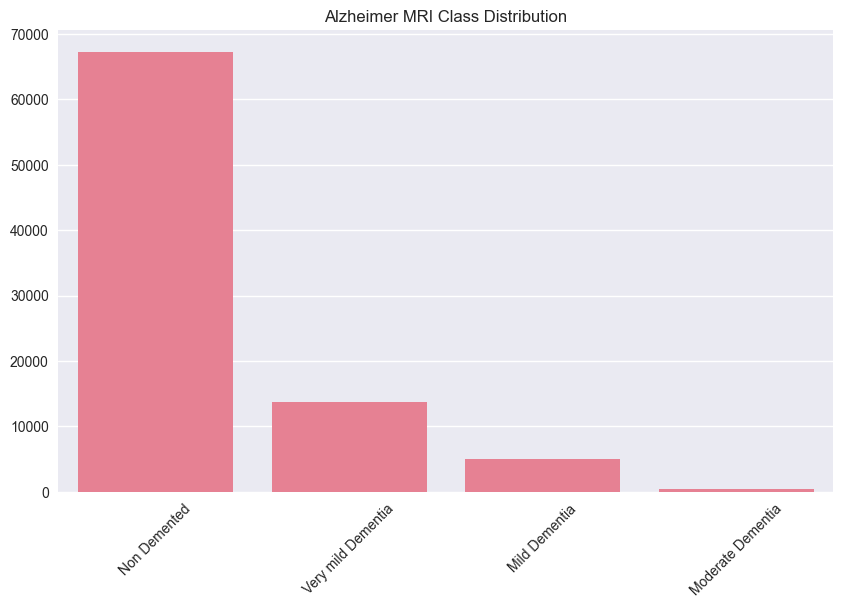

In [11]:

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
dataset_path = "/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data"

classes = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
class_counts = {cls: len(glob.glob(f"{dataset_path}/{cls}/*.jpg")) for cls in classes}

plt.figure(figsize=(10,6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Alzheimer MRI Class Distribution')
plt.xticks(rotation=45)
plt.show()

/var/folders/7m/_1cvfpq11cl9wf2mm0jlymjc0000gn/T/ipykernel_99032/3135755764.py:51: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



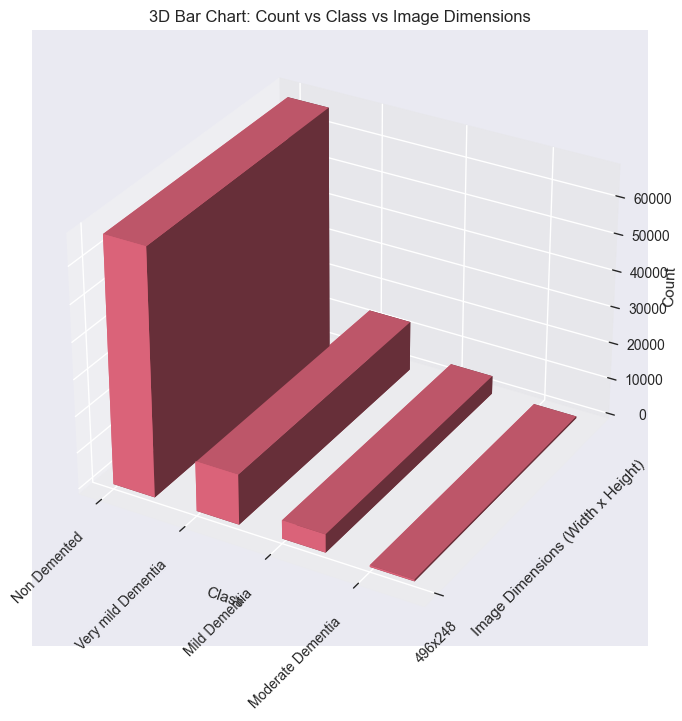

In [12]:


dimension_counts = {cls: {} for cls in classes}

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    image_files = glob.glob(os.path.join(cls_path, '*.jpg'))
    
    for img_file in image_files:
        with Image.open(img_file) as img:
            dimensions = img.size  # (width, height)
            if dimensions in dimension_counts[cls]:
                dimension_counts[cls][dimensions] += 1
            else:
                dimension_counts[cls][dimensions] = 1


x_labels = list(classes)
x_pos = np.arange(len(x_labels))
y_labels = set()
for cls in classes:
    y_labels.update(dimension_counts[cls].keys())
y_labels = sorted(y_labels)
y_pos = np.arange(len(y_labels))

x, y = np.meshgrid(x_pos, y_pos)
z = np.zeros_like(x)


for i, cls in enumerate(classes):
    for j, dim in enumerate(y_labels):
        z[j, i] = dimension_counts[cls].get(dim, 0)


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


dx = dy = 0.5
dz = z.flatten()
ax.bar3d(x.flatten(), y.flatten(), np.zeros_like(dz), dx, dy, dz, shade=True)


ax.set_xlabel('Class')
ax.set_ylabel('Image Dimensions (Width x Height)')
ax.set_zlabel('Count')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_yticks(y_pos)
ax.set_yticklabels([f'{dim[0]}x{dim[1]}' for dim in y_labels], rotation=45, ha='right')

plt.title('3D Bar Chart: Count vs Class vs Image Dimensions')
plt.tight_layout()
plt.show()

In [14]:
class_data = {
    'Class': list(class_counts.keys()),
    'Count': list(class_counts.values())
}

df_class = pd.DataFrame(class_data)

fig = px.treemap(
    df_class,
    path=['Class'],
    values='Count',
    title='Treemap: Class Proportions',
    color='Class',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.show()

Classes found: ['Mild Dementia', 'Very mild Dementia', 'Moderate Dementia', 'Non Demented']
Mild Dementia: 5002 images
Very mild Dementia: 13725 images
Moderate Dementia: 488 images
Non Demented: 67222 images


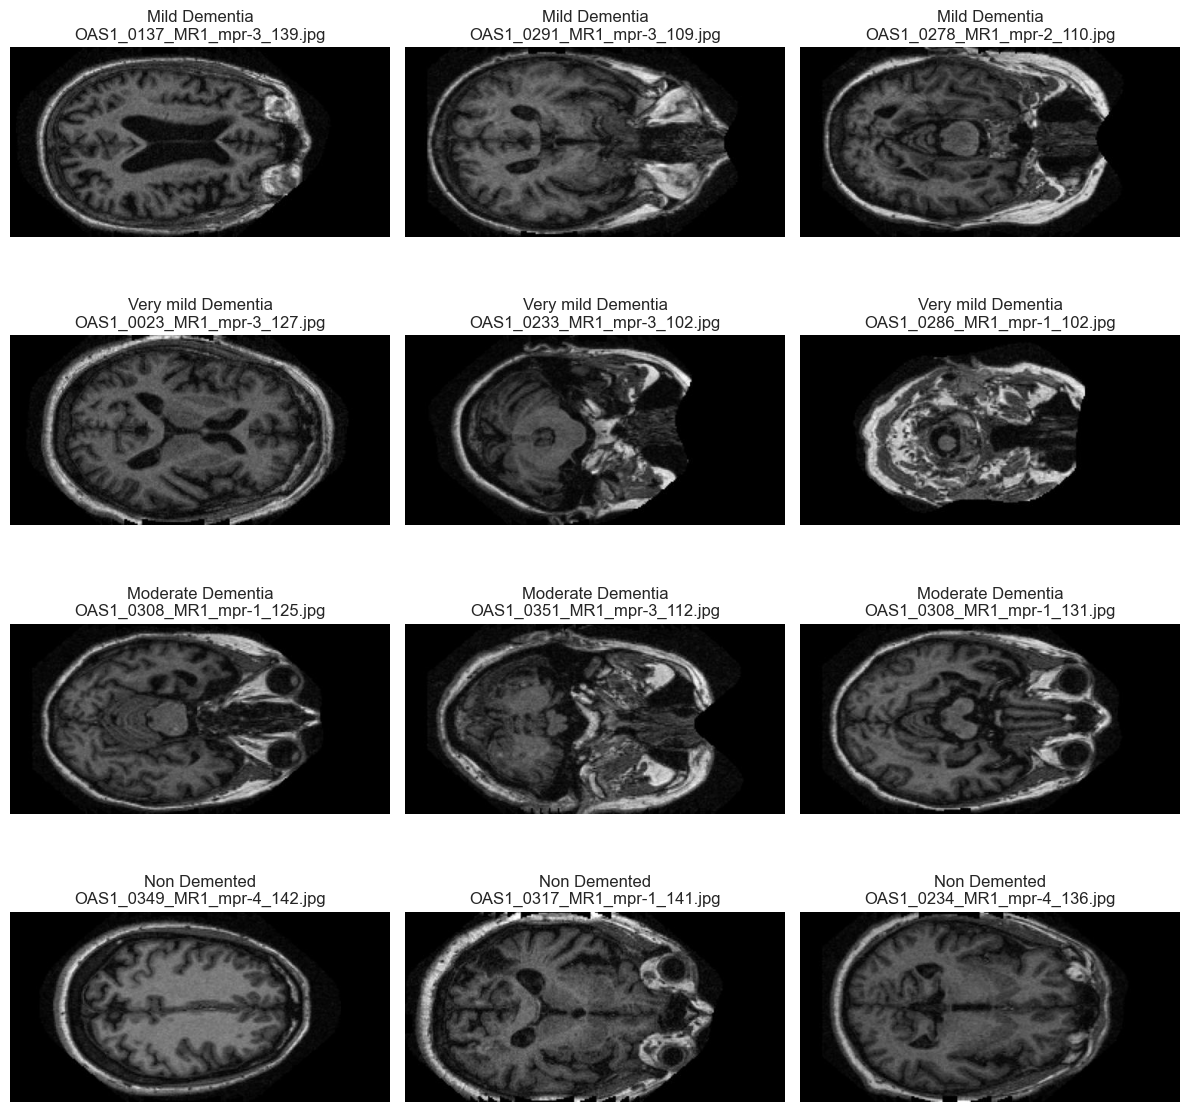

In [ ]:
dataset_path = '/Users/sajibhossain/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1/Data'

class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Classes found:", class_names)


for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    num_images = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])
    print(f"{class_name}: {num_images} images")

fig, axes = plt.subplots(len(class_names), 3, figsize=(12, 3 * len(class_names)))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
    for j in range(3):
        img_path = os.path.join(class_dir, image_files[j])
        img = Image.open(img_path)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(f"{class_name}\n{image_files[j]}")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

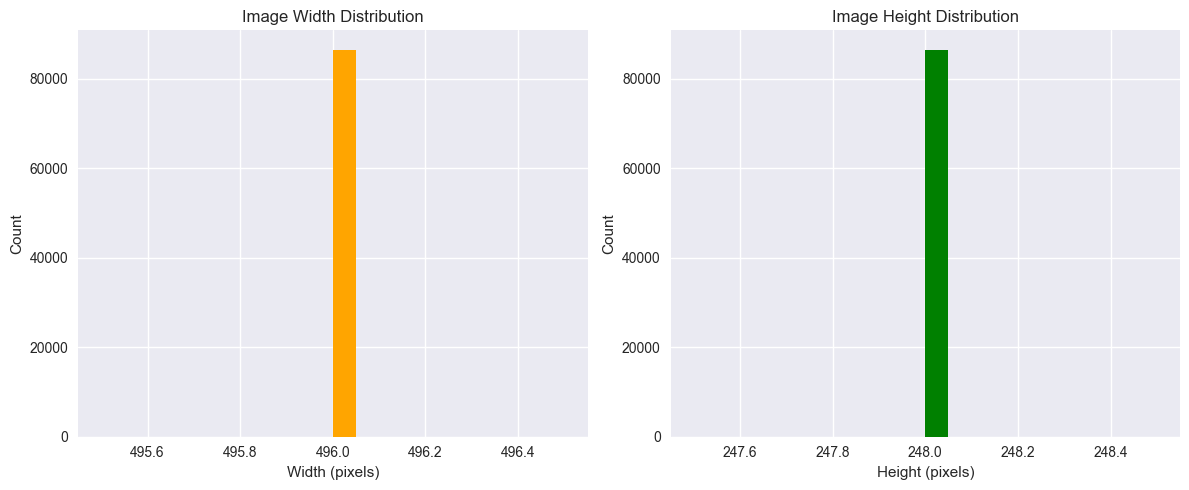

In [22]:


image_shapes = []
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    for fname in os.listdir(class_dir):
        if fname.endswith('.jpg'):
            img = Image.open(os.path.join(class_dir, fname))
            image_shapes.append(img.size)


widths, heights = zip(*image_shapes)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=20, color='orange')
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')
plt.subplot(1,2,2)
plt.hist(heights, bins=20, color='green')
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

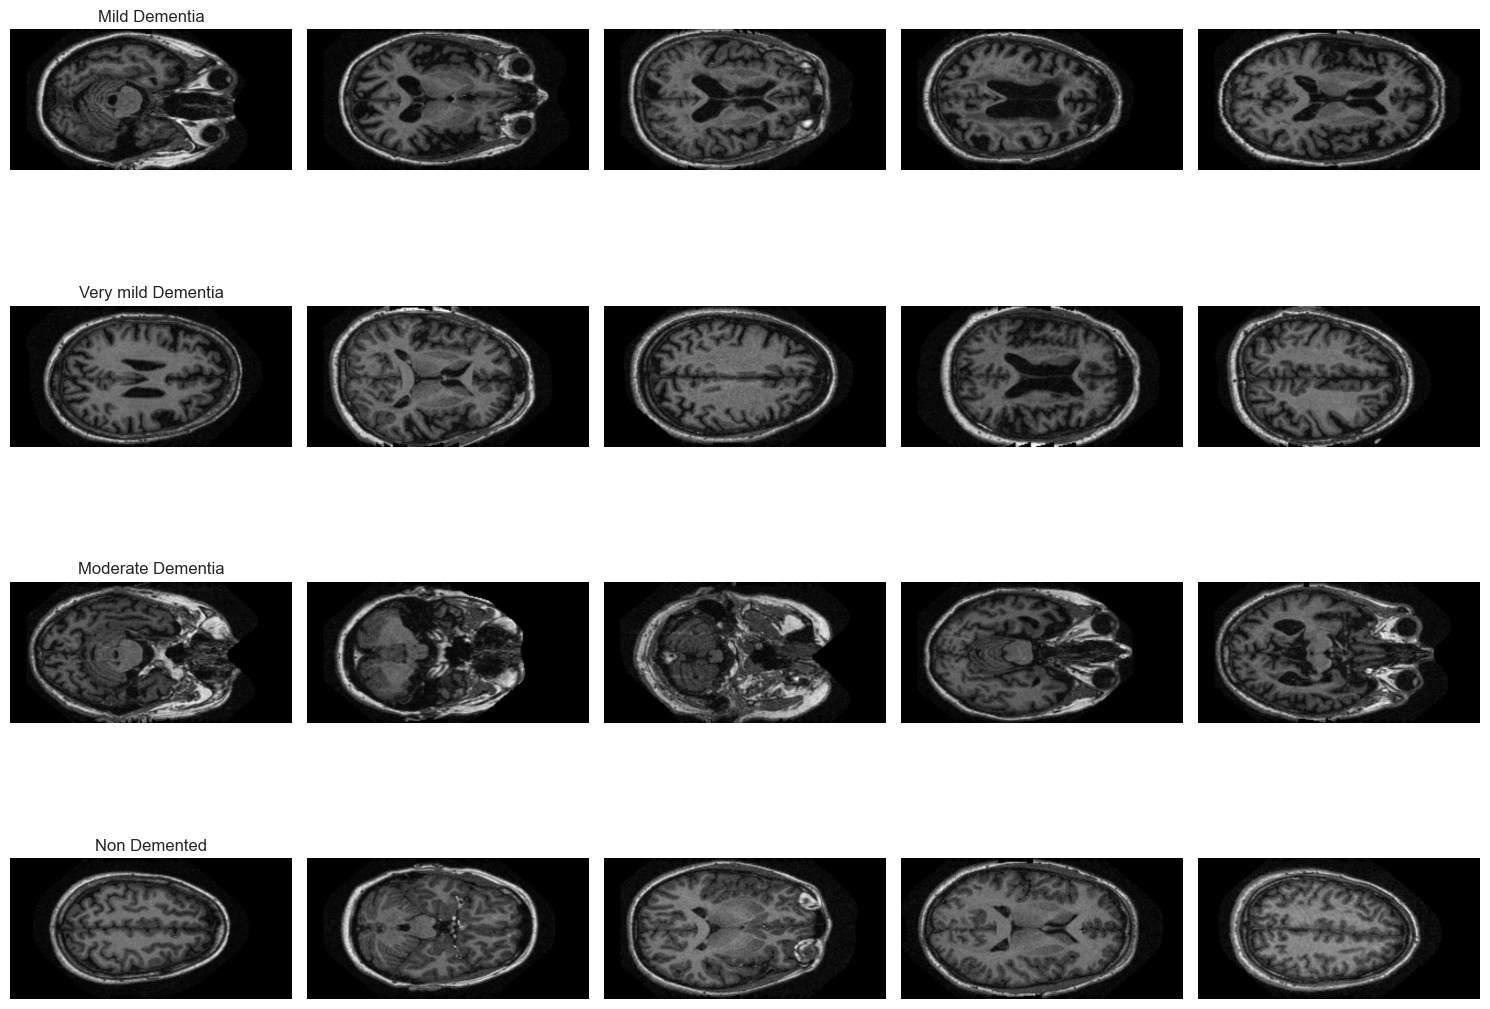

In [23]:


fig, axes = plt.subplots(len(class_names), 5, figsize=(15, 3 * len(class_names)))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
    samples = random.sample(image_files, min(5, len(image_files)))
    for j, fname in enumerate(samples):
        img = Image.open(os.path.join(class_dir, fname))
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(class_name if j == 0 else "")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

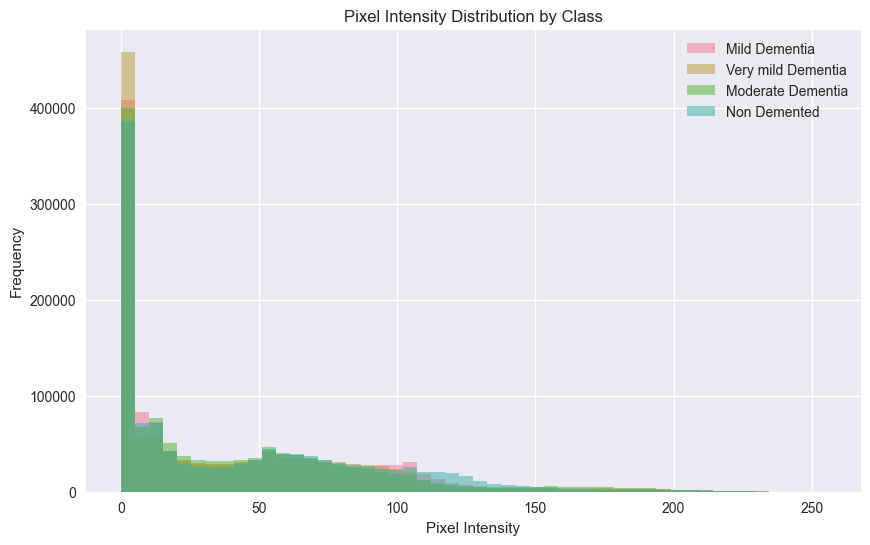

In [24]:
import numpy as np

plt.figure(figsize=(10,6))
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    pixels = []
    for fname in os.listdir(class_dir)[:10]:  
        img = Image.open(os.path.join(class_dir, fname)).convert('L')
        pixels.extend(np.array(img).flatten())
    plt.hist(pixels, bins=50, alpha=0.5, label=class_name)
plt.title('Pixel Intensity Distribution by Class')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

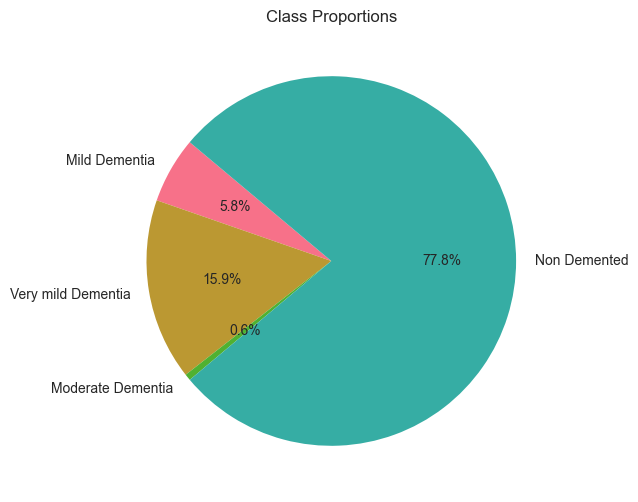

In [25]:
plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Proportions')
plt.show()

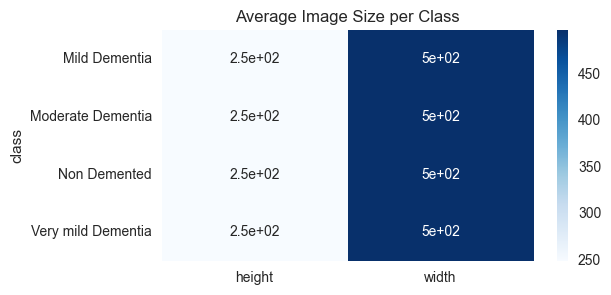

In [26]:
import pandas as pd
from seaborn import heatmap

# Collect image sizes per class
size_data = []
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    for fname in os.listdir(class_dir):
        if fname.endswith('.jpg'):
            img = Image.open(os.path.join(class_dir, fname))
            size_data.append({'class': class_name, 'width': img.width, 'height': img.height})

df = pd.DataFrame(size_data)
pivot = pd.pivot_table(df, index='class', values=['width', 'height'], aggfunc='mean')
plt.figure(figsize=(6,3))
heatmap(pivot, annot=True, cmap='Blues')
plt.title('Average Image Size per Class')
plt.show()

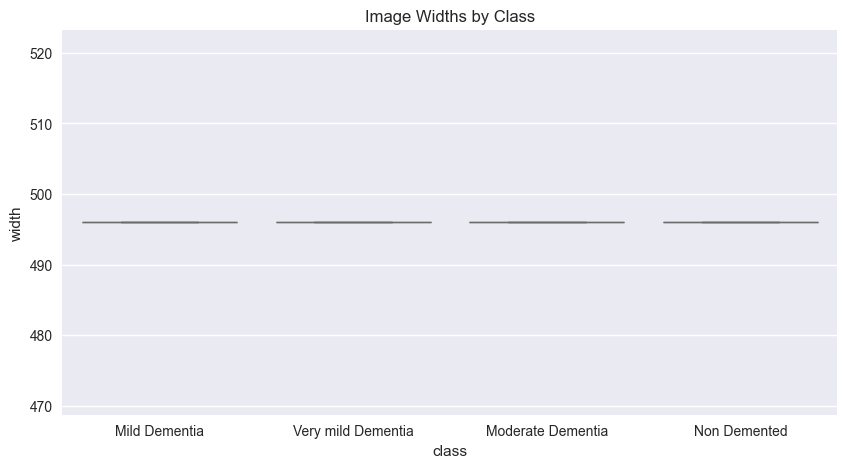

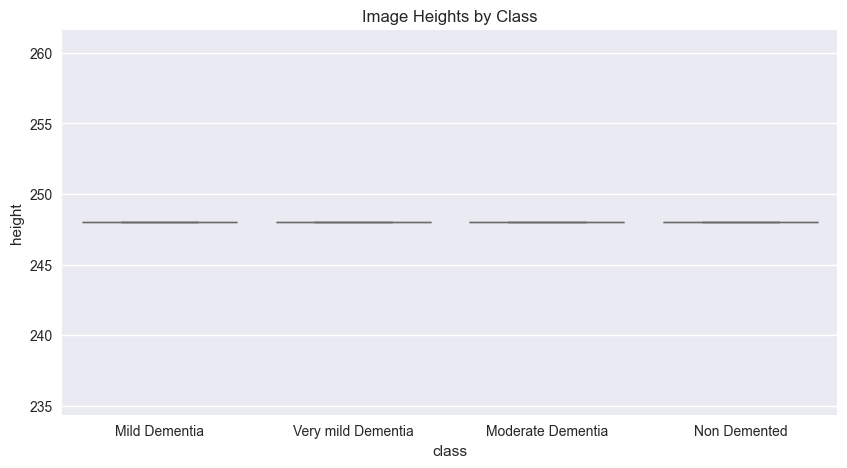

In [27]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.boxplot(x='class', y='width', data=df)
plt.title('Image Widths by Class')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='class', y='height', data=df)
plt.title('Image Heights by Class')
plt.show()

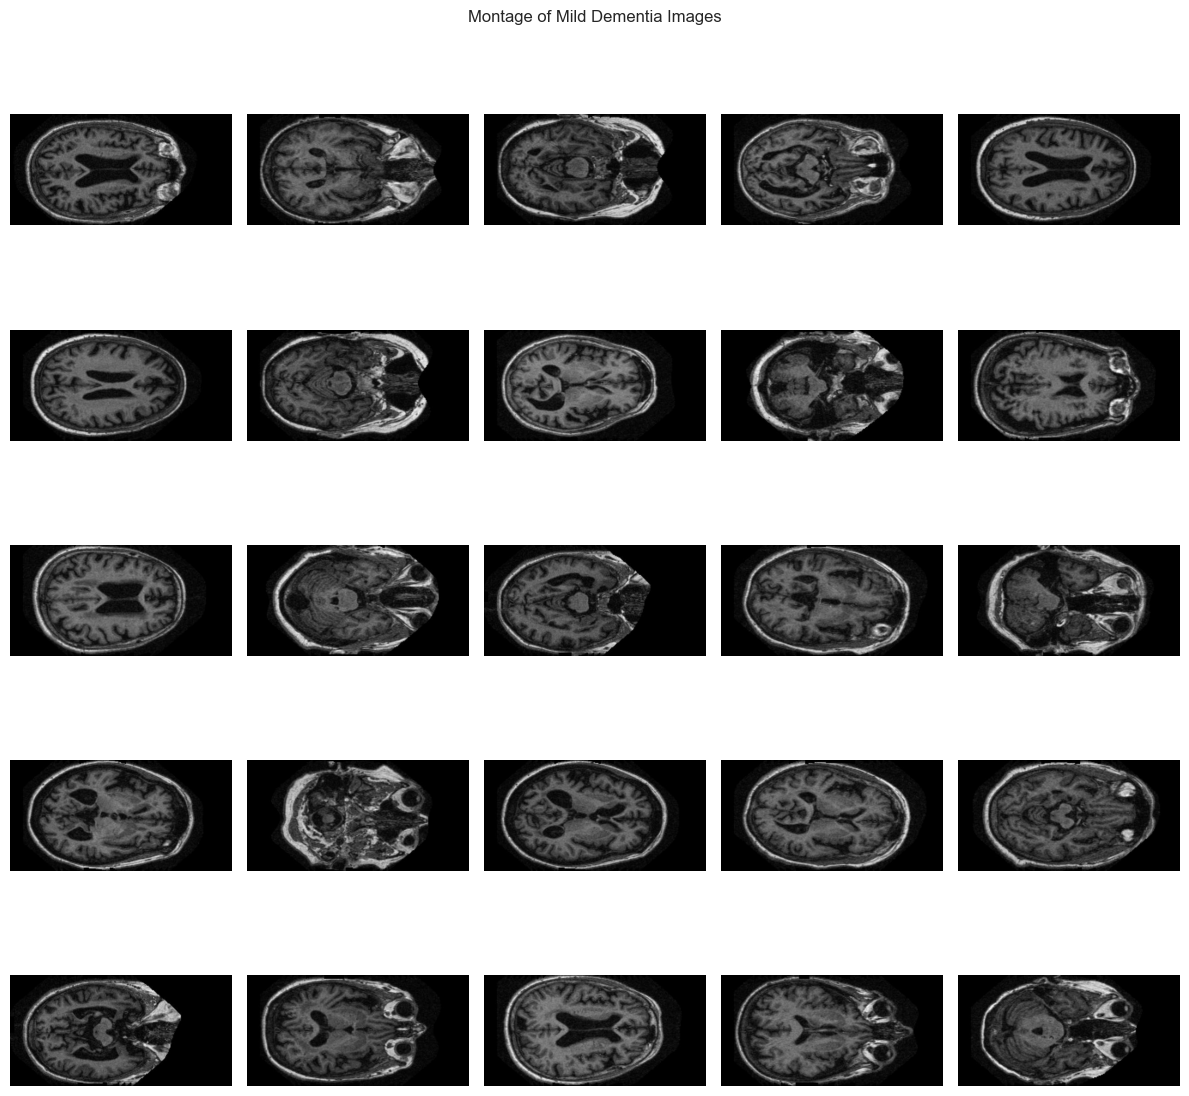

In [28]:
from math import ceil, sqrt

def plot_montage(class_name, max_images=25):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')][:max_images]
    n = ceil(sqrt(len(image_files)))
    fig, axes = plt.subplots(n, n, figsize=(12,12))
    for i, ax in enumerate(axes.flatten()):
        if i < len(image_files):
            img = Image.open(os.path.join(class_dir, image_files[i]))
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        else:
            ax.remove()
    plt.suptitle(f"Montage of {class_name} Images")
    plt.tight_layout()
    plt.show()

plot_montage(class_names[0])  

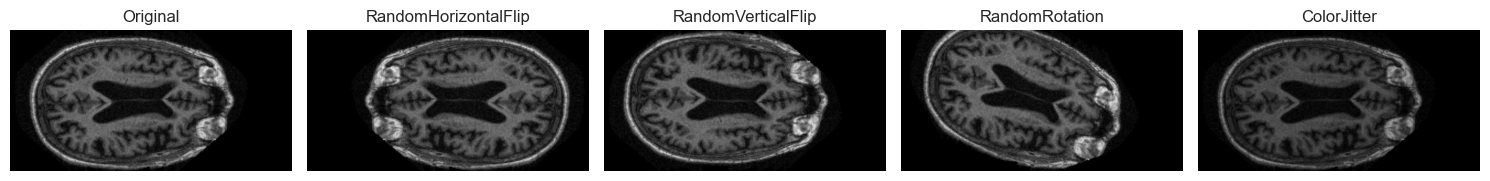

In [29]:


sample_img_path = os.path.join(dataset_path, class_names[0], os.listdir(os.path.join(dataset_path, class_names[0]))[0])
img = Image.open(sample_img_path)
augmentations = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5),
]

plt.figure(figsize=(15,3))
plt.subplot(1, len(augmentations)+1, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

for i, aug in enumerate(augmentations):
    aug_img = aug(img)
    plt.subplot(1, len(augmentations)+1, i+2)
    plt.imshow(np.array(aug_img))
    plt.title(type(aug).__name__)
    plt.axis('off')
plt.tight_layout()
plt.show()

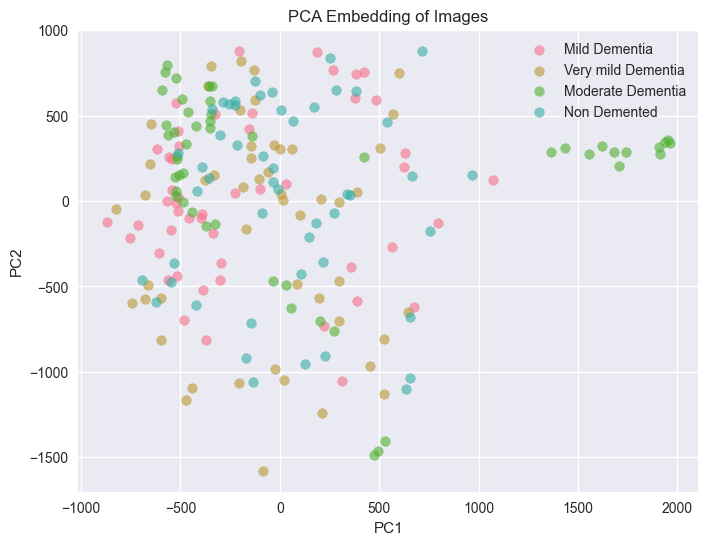

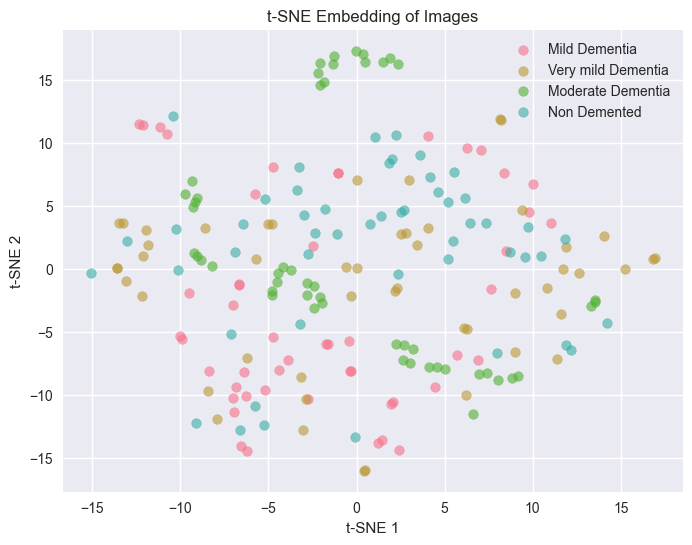

In [31]:

img_size = (64, 64)  
samples_per_class = 50  
features = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')][:samples_per_class]
    for fname in image_files:
        img = Image.open(os.path.join(class_dir, fname)).convert('L').resize(img_size)
        features.append(np.array(img).flatten())
        labels.append(class_name)

features = np.array(features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(8,6))
for class_name in class_names:
    idx = [i for i, l in enumerate(labels) if l == class_name]
    plt.scatter(features_pca[idx, 0], features_pca[idx, 1], label=class_name, alpha=0.6)
plt.title('PCA Embedding of Images')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
for class_name in class_names:
    idx = [i for i, l in enumerate(labels) if l == class_name]
    plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1], label=class_name, alpha=0.6)
plt.title('t-SNE Embedding of Images')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()